In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

trainset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform = transform)
testset = torchvision.datasets.STL10(root='./data', split='test', download=True, transform = transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers = 2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False, num_workers = 2)

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


truck   car airplane monkey


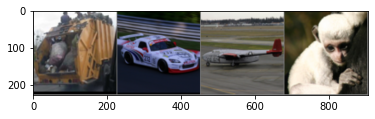

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    img = img.numpy().transpose(1,2,0)
    plt.imshow(img)

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
classes = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            
            nn.Conv2d(3, 64, 3, padding=1),nn.LeakyReLU(0.2), # 224x224x64
            nn.Conv2d(64, 64, 3, padding=1),nn.LeakyReLU(0.2), # 224x224x64
            nn.MaxPool2d(2, 2), # 112x112x64
            
            nn.Conv2d(64, 128, 3, padding=1),nn.LeakyReLU(0.2), # 112x112x128
            nn.Conv2d(128, 128, 3, padding=1),nn.LeakyReLU(0.2), # 112x112x128
            nn.MaxPool2d(2, 2), # 56x56x128
            
            nn.Conv2d(128, 256, 3, padding=1),nn.LeakyReLU(0.2), # 56x56x256
            nn.Conv2d(256, 256, 3, padding=1),nn.LeakyReLU(0.2), # 56x56x256
            nn.Conv2d(256, 256, 3, padding=1),nn.LeakyReLU(0.2), # 56x56x256
            nn.MaxPool2d(2, 2), # 28x28x256
            
            nn.Conv2d(256, 512, 3, padding=1),nn.LeakyReLU(0.2), # 28x28x512
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2), # 28x28x512
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2), # 28x28x512
            nn.MaxPool2d(2, 2), # 14x14x512
            
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2), # 14x14x512
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2), # 14x14x512
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2), # 14x14x512
            nn.MaxPool2d(2, 2) # 7x7x512
        )

        self.avg_pool = nn.AvgPool2d(7) # 1 x 1 x 512
        self.classifier = nn.Linear(512, 10) # 512 x 10
        
    def forward(self, x):

        
        features = self.conv(x)      
        x = self.avg_pool(features)       
        x = x.view(features.size(0), -1)      
        x = self.classifier(x)  
        return x, features

net = Net()
net = net.to(device)
param = list(net.parameters())
print(len(param))
for i in param:
    print(i.shape)

28
torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])


In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(net.parameters(),lr=0.00001)

In [ ]:
for epoch in range(70): 
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
    
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs,f = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if(loss.item() > 1000):
            print(loss.item())
            for param in net.parameters():
                print(param.data)

        running_loss += loss.item()
        if i % 50 == 49:    
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Finished Training')

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs, f = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
torch.save(net.state_dict(),'vgg19.pt')

In [ ]:
net2 = torch.load('./checkpoint/vgg19.pt')